<a href="https://colab.research.google.com/github/mertmisirli/1_Tensorflow/blob/main/Car_Plate_YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install tesseract-ocr -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!pip install pytesseract opencv-python

In [17]:
from google.colab import files
uploaded = files.upload()  # Görsel yüklemek için form çıkar


Saving plate1.jpg to plate1.jpg


🔍 Tahmin edilen plaka: OTUs


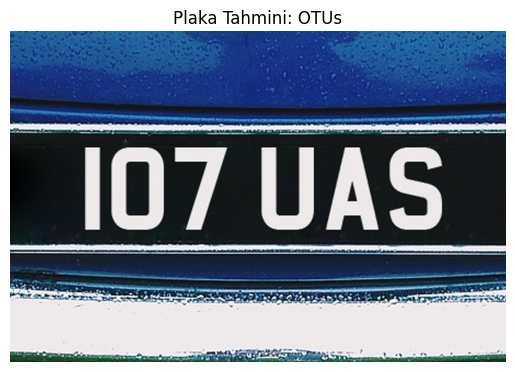

In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

# Yüklenen dosyayı al
file_name = list(uploaded.keys())[0]
img = cv2.imread(file_name)

# Griye çevir
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# (İsteğe bağlı) threshold ve filtre uygula
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# OCR uygula (psm 8: tek satır)
text = pytesseract.image_to_string(thresh, config='--psm 8')
print("🔍 Tahmin edilen plaka:", text.strip())

# Görüntüyü göster
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Plaka Tahmini: {text.strip()}")
plt.axis('off')
plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/car-plate-detection


In [ ]:
file_path = "/kaggle/input/car-plate-detection/annotations/Cars0.xml"

with open(file_path, 'r') as f:
    file_content = f.read()

#print(file_content)

In [ ]:
import os
import xml.etree.ElementTree as ET

# Klasörler
xml_dir = '/kaggle/input/car-plate-detection/annotations'
images_dir = '/kaggle/input//content/car-plate-detection/images'
#labels_dir = '/kaggle/input//content/car-plate-detection/labels'
labels_dir = '/kaggle/working/labels'
os.makedirs(labels_dir, exist_ok=True)

os.makedirs(labels_dir, exist_ok=True)

for xml_file in os.listdir(xml_dir):
    if not xml_file.endswith('.xml'):
        continue

    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Görüntü boyutları
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    yolo_labels = []
    for obj in root.findall('object'):
        cls = obj.find('name').text
        if cls != 'licence':
            continue

        cls_id = 0  # tek sınıf

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height

        yolo_labels.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    # Label dosyasını kaydet
    label_filename = xml_file.replace('.xml', '.txt')
    label_path = os.path.join(labels_dir, label_filename)
    with open(label_path, 'w') as f:
        f.write('\n'.join(yolo_labels))


In [ ]:
file_path = "/kaggle/working/labels/Cars0.txt"

with open(file_path, 'r') as f:
    file_content = f.read()

print(file_content)

0 0.645000 0.555970 0.386000 0.179104


In [ ]:
import shutil
import random
import os

# Resim ve label dizinleri (Kaggle’da)
images_dir = '/kaggle/input/car-plate-detection/images'
labels_dir = '/kaggle/working/labels'  # senin dönüştürdüğün label klasörü

# Yeni klasör yapısı (yazılabilir dizin)
dataset_dir = '/kaggle/working/dataset'
train_img_dir = os.path.join(dataset_dir, 'images/train')
val_img_dir = os.path.join(dataset_dir, 'images/val')
train_label_dir = os.path.join(dataset_dir, 'labels/train')
val_label_dir = os.path.join(dataset_dir, 'labels/val')

for d in [train_img_dir, val_img_dir, train_label_dir, val_label_dir]:
    os.makedirs(d, exist_ok=True)

# Tüm resimleri listele
all_images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.seed(42)
random.shuffle(all_images)

split_idx = int(len(all_images) * 0.8)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Kopyalama fonksiyonu
def copy_files(file_list, src_img_dir, dst_img_dir, src_label_dir, dst_label_dir):
    for file_name in file_list:
        # Resim kopyala
        shutil.copy(os.path.join(src_img_dir, file_name), os.path.join(dst_img_dir, file_name))
        # Label kopyala (uzantı .txt)
        label_name = file_name.rsplit('.', 1)[0] + '.txt'
        label_src_path = os.path.join(src_label_dir, label_name)
        label_dst_path = os.path.join(dst_label_dir, label_name)
        if os.path.exists(label_src_path):
            shutil.copy(label_src_path, label_dst_path)
        else:
            # Eğer label yoksa boş dosya oluştur (opsiyonel)
            with open(label_dst_path, 'w') as f:
                pass

copy_files(train_images, images_dir, train_img_dir, labels_dir, train_label_dir)
copy_files(val_images, images_dir, val_img_dir, labels_dir, val_label_dir)

print(f"Train set: {len(train_images)} images")
print(f"Val set: {len(val_images)} images")


Train set: 346 images
Val set: 87 images


In [ ]:
data_yaml = f"""
path: {dataset_dir}  # dataset root dizini
train: images/train
val: images/val

nc: 1
names: ['plate']
"""

with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

print("data.yaml oluşturuldu.")


data.yaml oluşturuldu.


In [ ]:
#!pip install ultralytics


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Ön eğitimli küçük model

model.train(data=os.path.join(dataset_dir, 'data.yaml'), epochs=5, imgsz=640)


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

100%|██████████| 755k/755k [00:00<00:00, 99.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 343MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3412.5±1102.7 MB/s, size: 496.8 KB)


train: Scanning /kaggle/working/dataset/labels/train... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 916.46it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 936.8±266.1 MB/s, size: 472.2 KB)


val: Scanning /kaggle/working/dataset/labels/val... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 401.98it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.08G      1.539      3.065      1.356         29        640: 100%|██████████| 22/22 [00:09<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         87         96    0.00326      0.885      0.271      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.33G       1.46      1.971      1.202         17        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         87         96      0.777      0.145      0.333      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.35G      1.442      1.763      1.239         19        640: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         87         96          1      0.217      0.653      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.37G      1.406      1.608      1.195         19        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         87         96      0.826      0.444      0.705      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.39G      1.407      1.541      1.191         27        640: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         87         96      0.766      0.683      0.723      0.438



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


                   all         87         96      0.766      0.683      0.722      0.438
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2c6690fb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU not available")


False
GPU not available


In [20]:
from google.colab import files
uploaded = files.upload()  # Görsel yüklemek için form çıkar


Saving car.jpg to car.jpg



image 1/1 /content/car.jpg: 352x640 1 plate, 37.4ms
Speed: 2.4ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict3


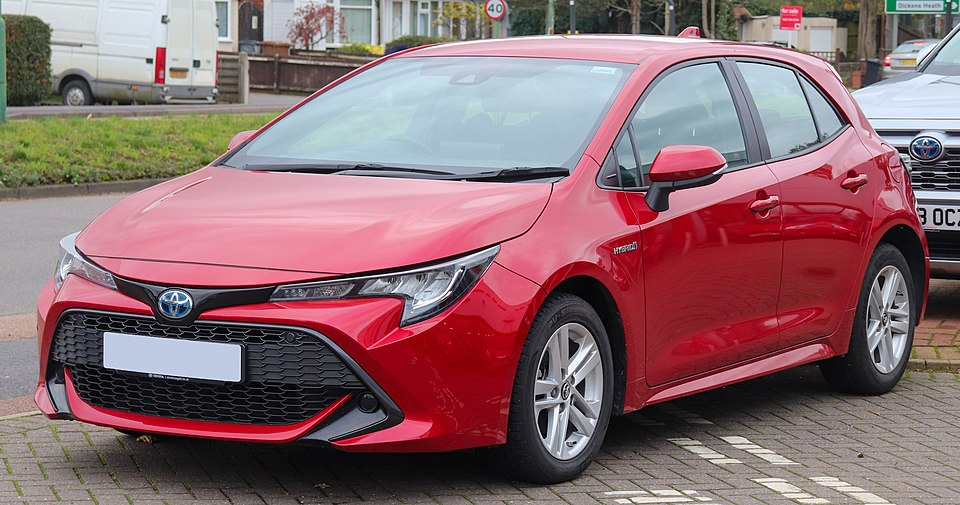

In [21]:
from ultralytics import YOLO
from IPython.display import Image, display

# Eğitilmiş modeli yükle
model = YOLO('runs/detect/train/weights/best.pt')

# Test etmek istediğin görselin yolunu belirt
results = model.predict(source='car.jpg', conf=0.25, save=True)

# Eğer Colab ya da Jupyter kullanıyorsan sonucu göster:
display(Image(filename='car.jpg'))  # dosya adı test görseline göre değişebilir


In [22]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 25.5 MB/s eta 0:00:00


In [23]:
!pip install opencv-python



image 1/1 /content/plate.jpeg: 480x640 2 plates, 38.9ms
Speed: 2.7ms preprocess, 38.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Plaka: TR (Güven: 1.00)
Plaka: 06   CD 2353 (Güven: 0.80)


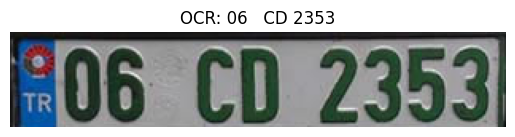

Plaka: TR (Güven: 1.00)
Plaka: 06 (Güven: 1.00)
Plaka: CD2353 (Güven: 0.61)


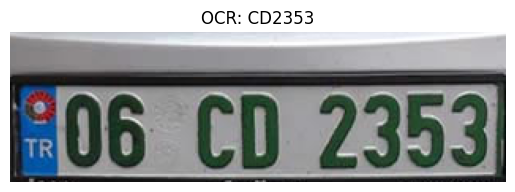

In [33]:
import cv2
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# Modeli yükle
model = YOLO("runs/detect/train/weights/best.pt")

# OCR motorunu başlat
reader = easyocr.Reader(['en'])  # Türk plakalar için 'en' yeterli

# Test görselini oku
#img_path = 'path/to/test_image.jpg'
img_path = 'plate.jpeg'
img = cv2.imread(img_path)

# YOLO ile tespit yap
results = model(img_path)

# Her tespit için işlem yap
for r in results:
    for box in r.boxes:
        # Kutu koordinatlarını al
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Plaka kısmını kırp
        plate_crop = img[y1:y2, x1:x2]

        # OCR ile oku
        ocr_result = reader.readtext(plate_crop)

        # Sonuçları yazdır
        for (bbox, text, conf) in ocr_result:
            print(f"Plaka: {text} (Güven: {conf:.2f})")

        # Görselle göster (isteğe bağlı)
        plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"OCR: {text}")
        plt.axis('off')
        plt.show()
